---

# UNIVERSITÀ DEGLI STUDI DI MILANO #

## Master in Data Science for Economics, Business and Finance ## 

### Analisi e Forecasting di una Serie Temporale ###

### Tesi di fine Master di: ###

### Claudio Panelli (Matr. A04422) ###

### Anno Accademico 2021/2022 ###

### Summary: ###

- Import Librerie Python
- Lettura dati della Time Series da CSV
- Analisi Descrittiva
- Forecasting
 - ARIMA
 - RNN
 - Prophet

---

### Import Librerie Python ###

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.express as px

import datetime
from tabulate import tabulate

from scipy.stats import boxcox

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

from dm_test import dm_test

import time
import math

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from keras.utils.vis_utils import plot_model

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (20, 6)

---

### Definizione parametri ###

In [3]:
filename = 'current.csv'

# nome della serie temporale scelta
timeseries = 'AWHMAN'
timestamp = 'timestamp'

# data di inizio e fine dell'analisi
start_date = '1979-12-31'
end_date = '2020-01-01'

# percentuale di split train/test
split_perc = 80

# data di split dati train/test
dt_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
dt_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
dt_split_date = dt_start_date+((dt_end_date-dt_start_date)/100)*split_perc

split_date = dt_split_date.strftime("%Y-%m-%d")

---

### Lettura dati della Time Series da CSV ###

In [4]:
df = pd.read_csv(filename, sep=',')

In [5]:
# fred data
df = df[['sasdate',timeseries]].iloc[1:, :]
df[timestamp] = pd.to_datetime(df['sasdate'])
df = df.drop('sasdate',axis=1)

In [6]:
df.shape

(758, 2)

In [7]:
print(df.head())
print(df.tail())

   AWHMAN  timestamp
1    40.2 1959-01-01
2    40.3 1959-02-01
3    40.4 1959-03-01
4    40.5 1959-04-01
5    40.7 1959-05-01
     AWHMAN  timestamp
754    41.3 2021-10-01
755    41.4 2021-11-01
756    41.3 2021-12-01
757    41.2 2022-01-01
758     NaN        NaT


---

### Analisi Descrittiva ###

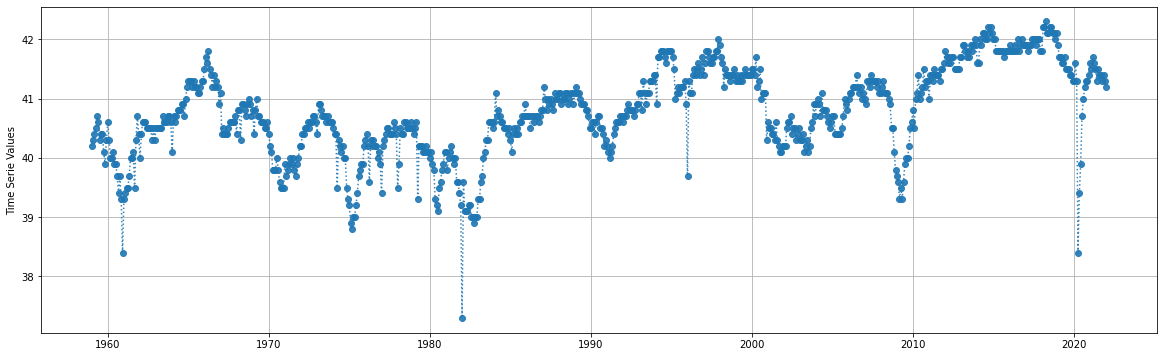

In [8]:
plt.figure(figsize=(20,6))
plt.plot(df[timestamp],df[timeseries],'o:',alpha=0.9)

plt.ylabel('Time Serie Values')
plt.grid()
plt.show()

In [9]:
# Selezione del periodo analizzato

df = df[df[timestamp] > datetime.datetime.strptime(start_date,"%Y-%m-%d")]
df = df[df[timestamp] < datetime.datetime.strptime(end_date,"%Y-%m-%d")]

In [10]:
df.shape

(480, 2)

In [11]:
print(df.head())
print(df.tail())

     AWHMAN  timestamp
253    40.0 1980-01-01
254    40.1 1980-02-01
255    39.9 1980-03-01
256    39.8 1980-04-01
257    39.3 1980-05-01
     AWHMAN  timestamp
728    41.5 2019-08-01
729    41.5 2019-09-01
730    41.4 2019-10-01
731    41.4 2019-11-01
732    41.3 2019-12-01


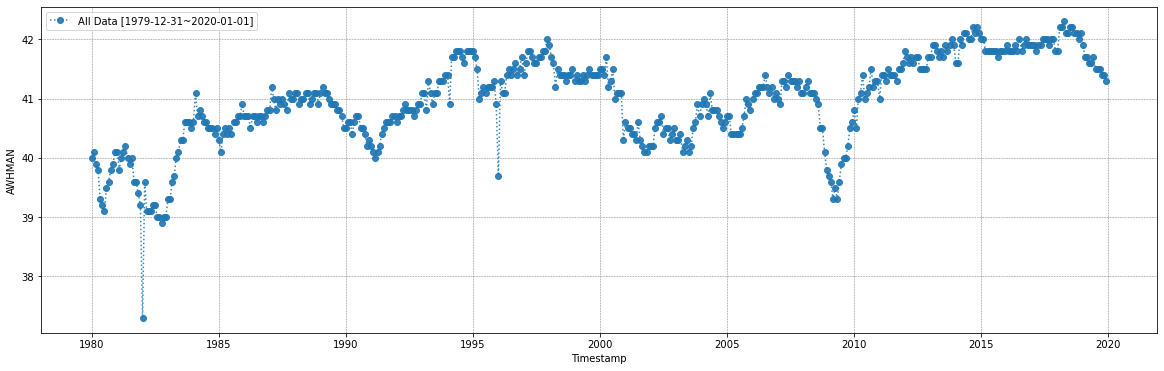

In [12]:
# Plot Serie Temporale

plt.figure(figsize=(20,6))

plt.plot(df[timestamp],df[timeseries],'o:',alpha=0.9)

plt.legend(['All Data ['+start_date+'~'+end_date+']'])
plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_00_entire', bbox_inches='tight')

plt.show()

In [16]:
# Decomponiamo la serie in trend e stagionalità ipotizzando che le componenti della TS siano additive
# ovvero y(t) = Level + Trend + Seasonality + Noise
# e una seasonality di 12 mesi
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

decomposition = seasonal_decompose(df[timeseries], model='additive', period=12)

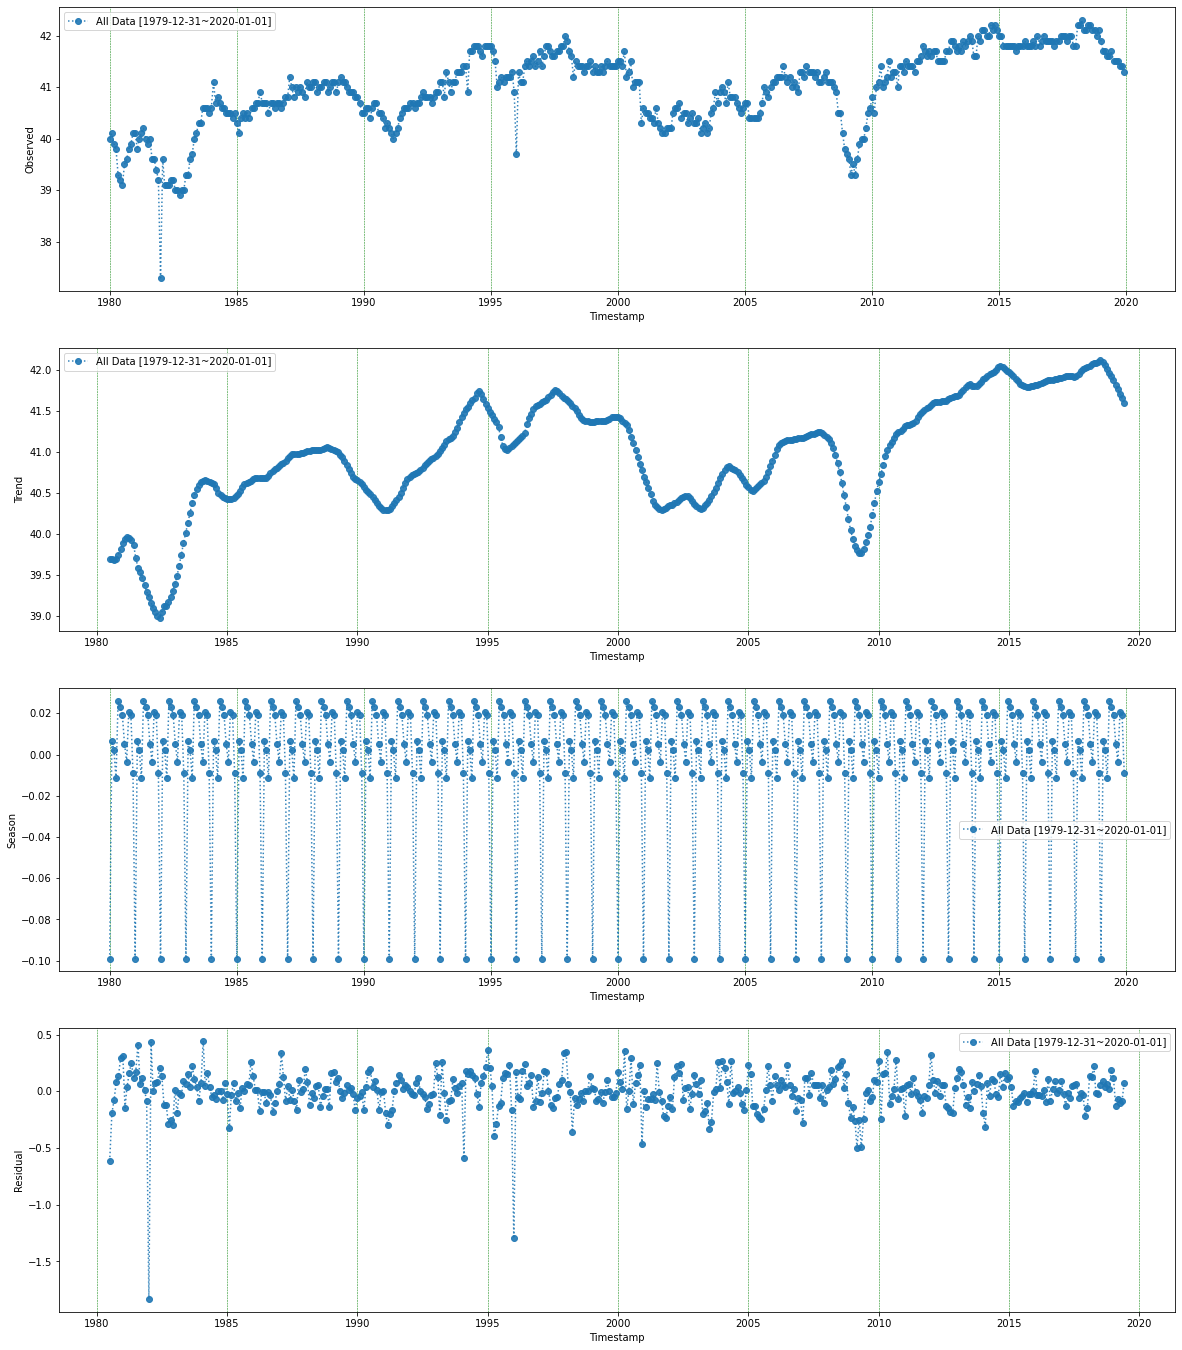

In [17]:
# Plot Trend, Seasonal e Residual

plt.figure(figsize=(20,24))

plt.subplot(411)
plt.plot(df[timestamp],decomposition.observed,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Observed')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(412)
plt.plot(df[timestamp],decomposition.trend,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Trend')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(413)
plt.plot(df[timestamp],decomposition.seasonal,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Season')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.subplot(414)
plt.plot(df[timestamp],decomposition.resid,'o:',alpha=0.9)
plt.legend(['All Data ['+start_date+'~'+end_date+']'])

plt.ylabel('Residual')
plt.xlabel('Timestamp')

plt.grid(axis = 'x', color = 'green', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_00_decomposition', bbox_inches='tight')
plt.show()

In [18]:
# Split della serie in Train e Test data

df_train = df[df[timestamp] <= datetime.datetime.strptime(split_date,"%Y-%m-%d")]
df_test = df[df[timestamp] > datetime.datetime.strptime(split_date,"%Y-%m-%d")]

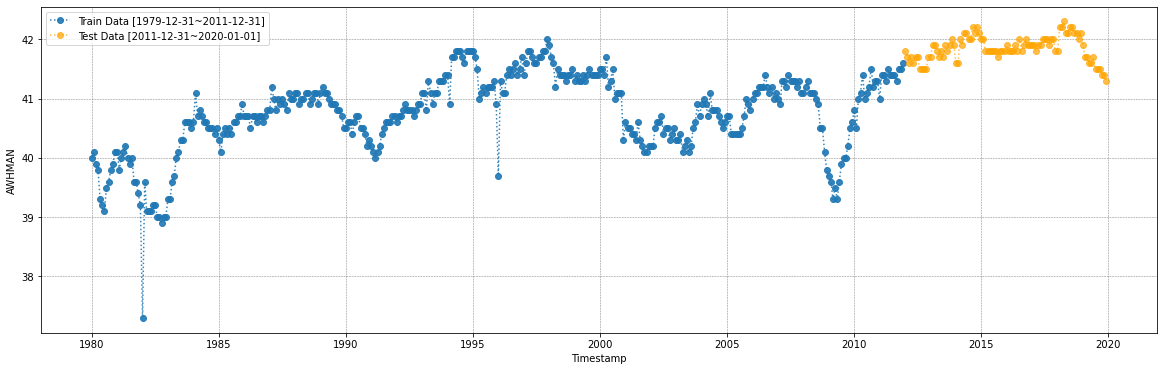

In [19]:
# Plot Serie Temporale divisa per Train e Test Data

plt.figure(figsize=(20,6))
plt.plot(df_train[timestamp],df_train[timeseries],'o:',alpha=0.9)
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

plt.legend(['Train Data ['+start_date+'~'+split_date+']','Test Data ['+split_date+'~'+end_date+']'])
plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_01_train-test', bbox_inches='tight')

plt.show()

In [20]:
#print(df_train.shape)
#print(df_test.shape)

---

### Forecasting ###

#### ARIMA ####

##### Test ADF per la Stazionarietà #####

- p_value = 0.027512 < 0.05 => possiamo rigettare l'ipotesi nulla: la serie è stazionaria.

Possiamo applicare i metodi ARMA/ARIMA direttamente alla serie senza dover differenziarla.

In [21]:
adf = adfuller(df_train[timeseries])

print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')

for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
    
if adf[1] < 0.05:
    print("Time Series is Stationary")
else:
    print("Time Series is Non-Stationary")

ADF Statistic: -3.087246
p-value: 0.027512
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Time Series is Stationary


##### Ricerca valore q #####

- il grafico ACF indicherebbe la scelta di un valore di q (per la componente MA(q)) elevato, il che implicherebbe la creazione di un modello complesso;

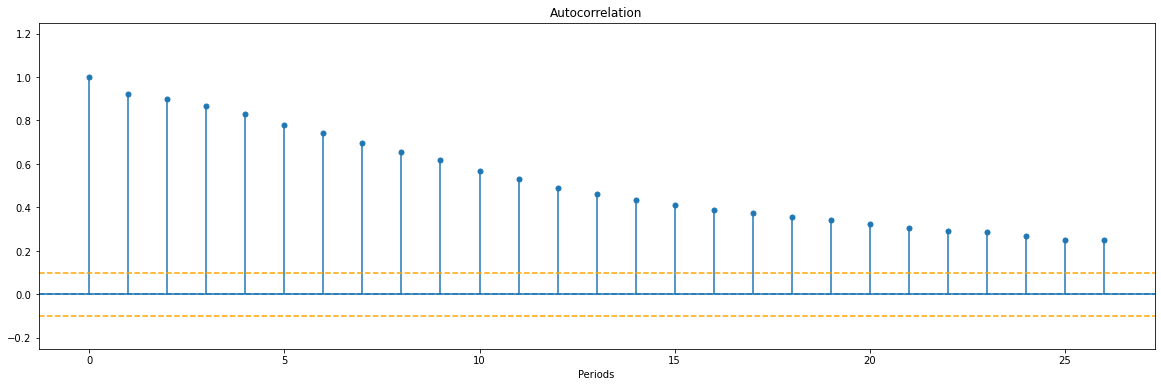

In [22]:
# ACF
acf_array = acf(df_train[timeseries])

# Plot the acf function
plot_acf(df_train[timeseries], alpha=None)

plt.axhline(y=0,linestyle='--')#, color='black')
plt.axhline(y=-1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')
plt.axhline(y=1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')

plt.xlabel('Periods')

plt.ylim([-0.25, 1.25])

plt.savefig('TS_02_acf', bbox_inches='tight')

plt.show()

##### Ricerca valore p #####

- il grafico PACF indica che un buon valore di p (per la componente AR(p)) potrebbe essere 1 oppure 2

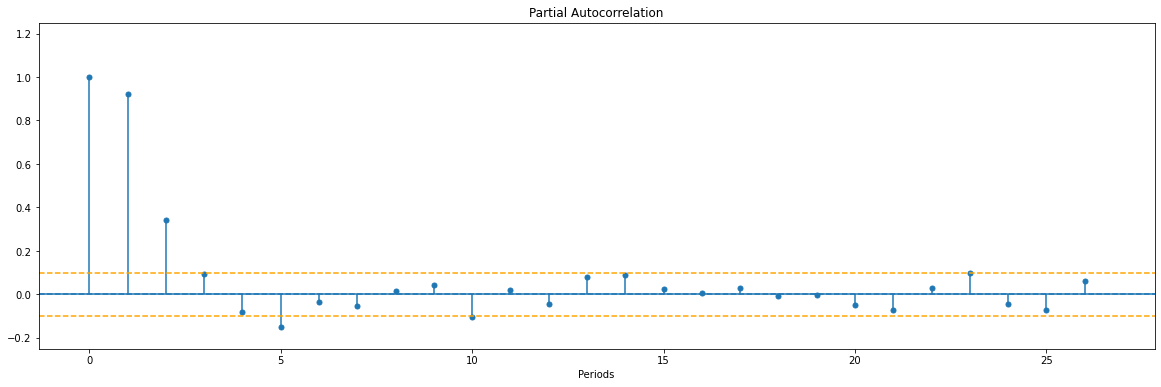

In [23]:
# PACF
pacf_array = pacf(df_train[timeseries])

# Plot the acf function
plot_pacf(df_train[timeseries], alpha=1) #, color='r');

plt.axhline(y=0,linestyle='--')# ,color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')
plt.axhline(y=1.96/np.sqrt(len(df_train[timeseries])),linestyle='--',color='orange')

plt.xlabel('Periods')

plt.ylim([-0.25, 1.25])

plt.savefig('TS_03_pacf', bbox_inches='tight')

##### Selezionare con un criterio informativo Akaike o Bayesian un modello ARMA(p,q) ######

- Il test ADF precedentemente eseguito ci ha informato che la serie è stazionaria, quindi non differenziamo la serie e procediamo a cercare un modello ARIMA(p,0,q) per la serie y_t
  - dove: p = [0,1,2,3], d = 0, q = [0,1,2,3]

- dai grafici ACF e PACF ci aspettiamo un q > 1 e un p >= 2

In [24]:
p_min = 1
p_max = 3

d_min = 0
d_max = 0

q_min = 1
q_max = 3

idx = 0

models_list = []

for d in range(d_min, d_max+1):
    for p in range(0, p_max+1):
        for q in range(0, q_max+1):

            model_list=[]

            model_list.append(idx)
            model_list.append(p)
            model_list.append(d)
            model_list.append(q)

            idx=idx+1
            model = ARIMA(df_train[timeseries], order=(p,d,q))
            model.fit(method_kwargs={"warn_convergence": False})
            results = model.fit()

            model_list.append(round(results.aic,2))
            model_list.append(round(results.bic,2))
            model_list.append(pd.DataFrame(results.resid))

            model_list.append(model)
            model_list.append(results)        
            models_list.append(model_list)

np_models_list = np.array(models_list)

In [25]:
print(tabulate(np_models_list[:,:6],headers=['model_nbr','p','d','q','AIC','BIC']))

  model_nbr    p    d    q     AIC     BIC
-----------  ---  ---  ---  ------  ------
          0    0    0    0  775.18  783.08
          1    0    0    1  478.27  490.12
          2    0    0    2  331.95  347.76
          3    0    0    3  237.62  257.37
          4    1    0    0   42.78   54.63
          5    1    0    1   -2.95   12.85
          6    1    0    2   -7.89   11.87
          7    1    0    3  -12.13   11.57
          8    2    0    0   -4.16   11.64
          9    2    0    1   -4.69   15.06
         10    2    0    2  -10.83   12.87
         11    2    0    3  -10.18   17.48
         12    3    0    0   -6.23   13.53
         13    3    0    1   -4.87   18.84
         14    3    0    2  -11.02   16.64
         15    3    0    3   -9.55   22.05


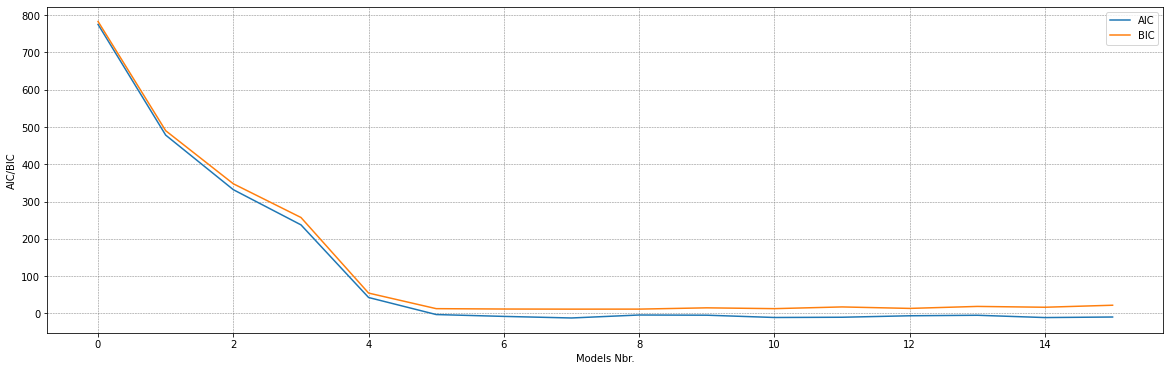

In [26]:
# Lineplot AIB/BIC

df_models_list = pd.DataFrame( np_models_list[:,:6],columns=['model_nbr','p','d','q','AIC','BIC'] )
df_models_list[['AIC','BIC']].plot()

plt.xlabel('Models Nbr.')
plt.ylabel('AIC/BIC')

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.savefig('TS_04_aic-bic', bbox_inches='tight')

plt.show()

In [27]:
fig = px.line(df_models_list, x="model_nbr", y=["AIC","BIC"], title='AIC/BIC')
fig.show()

##### Predizione one-step con rimodellazione ######

In [28]:
# Modelliamo un ARIMA (p,d,q) e facciamo forecast sul test dataset

p = 1
d = 0
q = 3

In [29]:
start = time.time()

In [30]:
# Ad ogni passo del for aggiungo alla history un nuovo elemento preso dal "df_test"

predictions_arima = list()

history = df_train[timeseries]

len_test = df_test.shape[0]

for i in range(len_test):
    
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    
    yhat = model_fit.forecast().iloc[0]    # forecast
    
    predictions_arima.append(yhat)
    
    obs = df_test[timeseries].iloc[i]              # valore osservato da df_test
    #print(obs)
    
    history = history.append( pd.Series(obs) )   # all'history aggiungo il valore osservato del df_test (non uso la predizione)

In [31]:
end = time.time()
print(end - start)

26.75631809234619


In [32]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_arima'] = pd.Series(predictions_arima)

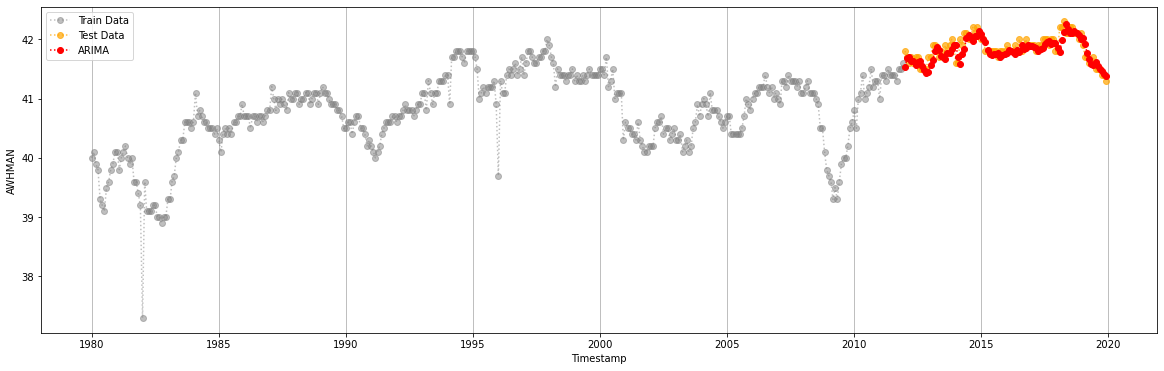

In [33]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp],df_train[timeseries],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_arima'],'o:',alpha=1, color='red')

plt.legend(['Train Data','Test Data','ARIMA'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_arima-pred-day', bbox_inches='tight')
plt.show()

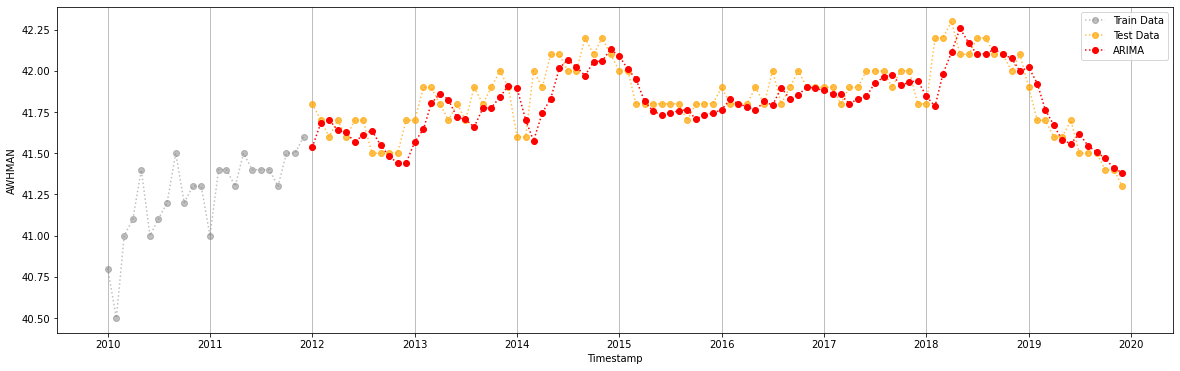

In [34]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[360:],df_train[timeseries].iloc[360:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_arima'],'o:',alpha=1, color='red')

plt.legend(['Train Data','Test Data','ARIMA'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_arima-pred-day_zoom_red', bbox_inches='tight')
plt.show()

In [35]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_arima'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_arima'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.016666165452949782
RMSE  0.1290975036666077
MAE 0.09826835699813663


In [36]:
df_test_results = df_test[ [timestamp,timeseries,'pred_arima'] ].copy()

#### RNN ####

In [37]:
# Setup variabili usate per la RNN

input_length = 10
hidden_length = 24

nbr_val_data = 15

epochs = 300

start_to_plot_train =  360

In [38]:
# Creiamo il dataset per l'addestramento (supervised) della RNN:
# dal df_train => Xtrain,Ytrain e Xval,Yval

# Eseguiamo la validazione sulle ultimi Nval dati del "df_train"
Nval = nbr_val_data

# Convertiamo il DataFrame "df_train" in un array Numpy
series = df_train[timeseries].dropna().to_numpy()

# Lunghezza dell'input
T = input_length

# Creiamo gli array X,Y usati nell'addestramento:
# X: array di T elementi => [t,...t+T-1]
# Y: valore T-esimo successivo => [t+T]

X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

# Split di X e Y in (Xtrain, Ytrain) e (Xtest, Ytest)
Xtrain, Ytrain = X[:-Nval], Y[:-Nval]
Xval, Yval = X[-Nval:], Y[-Nval:]

In [39]:
#print(df_train.shape)
#print(Xtrain.shape,Ytrain.shape)
#print(Xval.shape,Yval.shape)
#print(df_test.shape)

In [40]:
# Definiamo la RNN

i = Input(shape=(T, 1))
x = LSTM(hidden_length)(i)
x = Dense(1)(x)
model = Model(i, x)

In [41]:
# Stampiamo un summary della rete

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


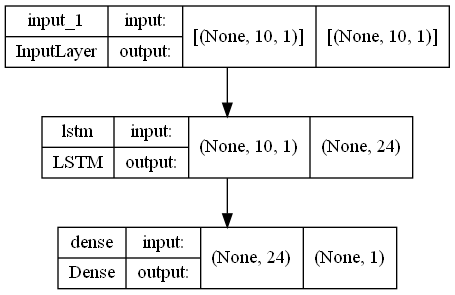

In [42]:
plot_model(model, to_file='TS_05_model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
# Configuriamo funzione di loss e optimizer della rete

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [44]:
# Istruimao la rete sul train (Xtrain, Ytrain) e la validiamo sul test (Xtest, Ytest)

r = model.fit(
  Xtrain,
  Ytrain,
  epochs=epochs,
  validation_data=(Xval, Yval)
)

Epoch 1/300
12/12 [==============================] - 2s 44ms/step - loss: 1654.4846 - val_loss: 1696.3702
Epoch 2/300
12/12 [==============================] - 0s 8ms/step - loss: 1641.0752 - val_loss: 1681.6134
Epoch 3/300
12/12 [==============================] - 0s 7ms/step - loss: 1624.4274 - val_loss: 1661.7587
Epoch 4/300
12/12 [==============================] - 0s 8ms/step - loss: 1602.8823 - val_loss: 1638.3160
Epoch 5/300
12/12 [==============================] - 0s 7ms/step - loss: 1579.7726 - val_loss: 1614.4585
Epoch 6/300
12/12 [==============================] - 0s 7ms/step - loss: 1551.8228 - val_loss: 1575.9969
Epoch 7/300
12/12 [==============================] - 0s 7ms/step - loss: 1498.7511 - val_loss: 1500.8995
Epoch 8/300
12/12 [==============================] - 0s 8ms/step - loss: 1412.0620 - val_loss: 1405.0078
Epoch 9/300
12/12 [==============================] - 0s 8ms/step - loss: 1325.9675 - val_loss: 1329.4484
Epoch 10/300
12/12 [==============================] - 

12/12 [==============================] - 0s 7ms/step - loss: 22.6390 - val_loss: 27.7862
Epoch 159/300
12/12 [==============================] - 0s 7ms/step - loss: 21.8104 - val_loss: 26.8615
Epoch 160/300
12/12 [==============================] - 0s 7ms/step - loss: 21.0033 - val_loss: 25.9622
Epoch 161/300
12/12 [==============================] - 0s 6ms/step - loss: 20.2221 - val_loss: 25.0945
Epoch 162/300
12/12 [==============================] - 0s 7ms/step - loss: 19.4661 - val_loss: 24.2508
Epoch 163/300
12/12 [==============================] - 0s 7ms/step - loss: 18.7368 - val_loss: 23.4299
Epoch 164/300
12/12 [==============================] - 0s 7ms/step - loss: 18.0279 - val_loss: 22.6330
Epoch 165/300
12/12 [==============================] - 0s 7ms/step - loss: 17.3417 - val_loss: 21.8613
Epoch 166/300
12/12 [==============================] - 0s 7ms/step - loss: 16.6808 - val_loss: 21.1153
Epoch 167/300
12/12 [==============================] - 0s 7ms/step - loss: 16.0381 - va

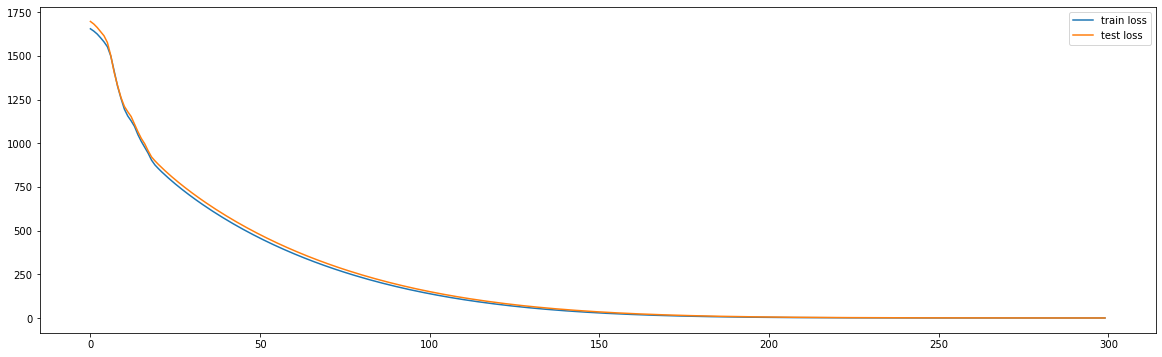

In [45]:
# Plot loss history del train e del test:
# possiamo vedere che convergono

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

##### Predizione one-step senza rimodellazione ######

In [46]:
start = time.time()

In [47]:
# Creiamo il dataset per eseguire le predizioni sul modello di RNN costruito

# Lunghezza dell'input == T

# Ultimi T elementi del df_train
series_trail_last10 = df_train[timeseries].iloc[-T:].to_numpy()

# Elementi del df_test
series_test_all = df_test[timeseries].dropna().to_numpy()

# Uniamo i due array Numpy
series_test = np.append(series_trail_last10, series_test_all)

# Creiamo gli array X,Y usati nell'addestramento:
# X: array di T elementi => [t,...t+T-1]
# Y: valore T-esimo successivo => [t+T]

X_test = []
Y_test = []
for t in range(len(series_test) - T):
  x = series_test[t:t+T]
  X_test.append(x)
  y = series[t+T]
  Y_test.append(y)

X_test = np.array(X_test).reshape(-1, T, 1)
Y_test = np.array(Y_test)

In [48]:
end = time.time()
print(end - start)

0.04933333396911621


In [49]:
forecast = model.predict(X_test).flatten()

In [50]:
#forecast

In [51]:
df_test['pred_RNN'] = forecast

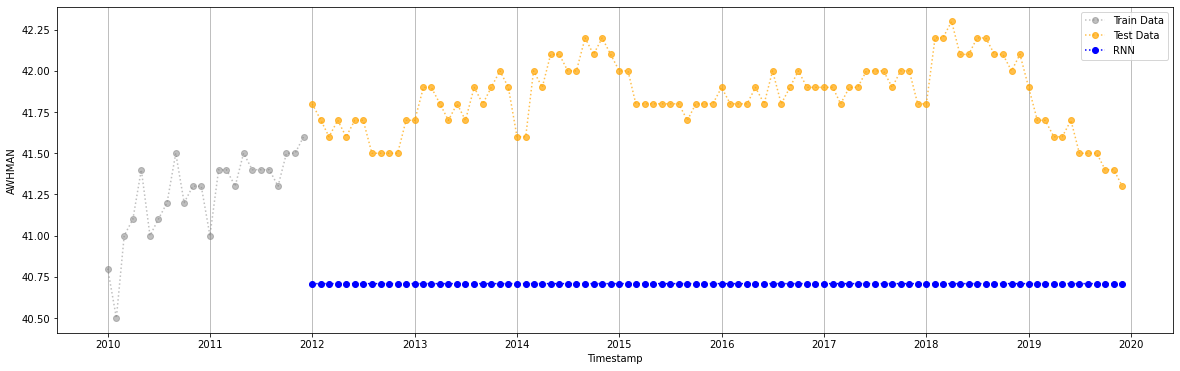

In [52]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_RNN'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_RNN-pred-day_zoom_blue', bbox_inches='tight')
plt.show()

In [53]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_RNN'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_RNN'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  1.334431424421212
RMSE  1.1551759279093432
MAE 1.136463658014933


##### Predizione one-step con rimodellazione ######

In [54]:
# Setup variabili usate per la RNN

input_length = 10
hidden_length = 24

nbr_val_data = 15

epochs = 300

start_to_plot_train =  360

df_train_rnn = df_train.copy()

In [55]:
start = time.time()

In [56]:
predictions_rnn = list()

len_test = df_test.shape[0]

for i_loop in range(len_test):

    # Creiamo il dataset per l'addestramento (supervised) della RNN:
    # dal df_train => Xtrain,Ytrain e Xval,Yval

    # Eseguiamo la validazione sulle ultimi Nval dati del "df_train"
    Nval = nbr_val_data

    # Convertiamo il DataFrame "df_train" in un array Numpy
    series = df_train_rnn[timeseries].dropna().to_numpy()

    # Lunghezza dell'input
    T = input_length

    # Creiamo gli array X,Y usati nell'addestramento:
    # X: array di T elementi => [t,...t+T-1]
    # Y: valore T-esimo successivo => [t+T]

    X = []
    Y = []
    for t in range(len(series) - T):
      x = series[t:t+T]
      X.append(x)
      y = series[t+T]
      Y.append(y)

    X = np.array(X).reshape(-1, T, 1)
    Y = np.array(Y)

    # Split di X e Y in (Xtrain, Ytrain) e (Xtest, Ytest)
    Xtrain, Ytrain = X[:-Nval], Y[:-Nval]
    Xval, Yval = X[-Nval:], Y[-Nval:]

    # RNN
    i = Input(shape=(T, 1))
    x = LSTM(24, return_sequences=True)(i)
    x = GlobalMaxPooling1D()(x)
    x = Dense(1)(x)
    model = Model(i, x)

    # Configuriamo funzione di loss e optimizer della rete

    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )

    # Istruimao la rete sul train (Xtrain, Ytrain) e la validiamo sul test (Xtest, Ytest)

    r = model.fit(
      Xtrain,
      Ytrain,
      epochs=epochs,
      validation_data=(Xval, Yval),
      verbose=0
    )

    # Prendiamo gli ultimi 10 punti della X e prediciamo il valore T+1
    X = np.array(X).reshape(-1, T, 1)

    X_input10 = X[:1]

    # Prediciamo T+1
    forecast = model.predict(X_input10).flatten()

    # Aggiungo il forecast nella lista predictions_rnn
    predictions_rnn.append(forecast[0])

    # Prendo il valore i-esimo del df_test
    obs = df_test[timeseries].iloc[i_loop]
    obs_ts = df_test[timestamp].iloc[i_loop]

    # Aggiungo
    df_train_rnn = df_train_rnn.append({'y': obs, 'ds': obs_ts}, ignore_index = True) 

    #print(i_loop+1,"/",len_test)

In [57]:
end = time.time()
print(end - start)

2318.3984355926514


In [58]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_RNN_11'] = pd.Series(predictions_rnn)

In [59]:
df_test

AWHMAN  timestamp  pred_RNN_11
0     41.8 2012-01-01    40.516655
1     41.7 2012-02-01    40.589138
2     41.6 2012-03-01    40.545288
3     41.7 2012-04-01    40.685734
4     41.6 2012-05-01    40.594437
..     ...        ...          ...
91    41.5 2019-08-01    40.749233
92    41.5 2019-09-01    40.604286
93    41.4 2019-10-01    40.525978
94    41.4 2019-11-01    40.705635
95    41.3 2019-12-01    40.631573

[96 rows x 3 columns]

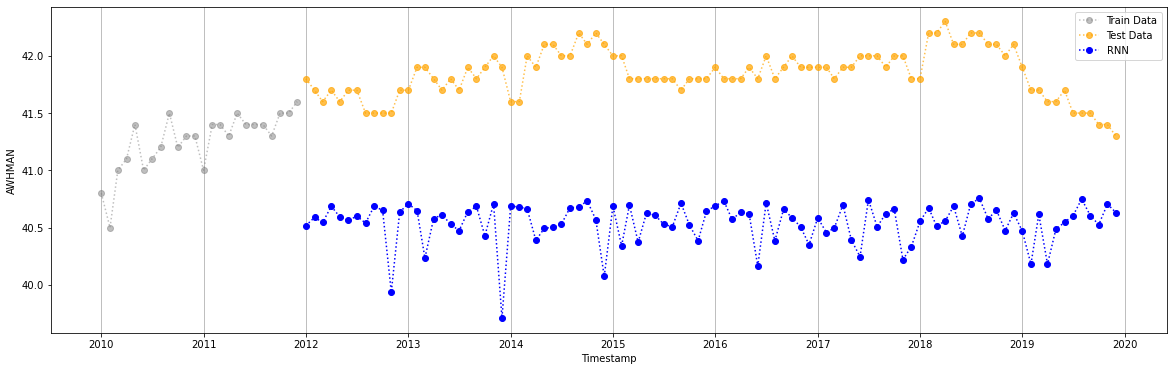

In [60]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[360:],df_train[timeseries].iloc[360:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_RNN_11'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_rnn-pred-day_zoom_00_blue', bbox_inches='tight')
plt.show()

In [61]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_RNN_11'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_RNN_11'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  1.775873785584414
RMSE  1.3326191449864488
MAE 1.3044012943903602


In [62]:
df_test_results['pred_RNN_11'] = df_test['pred_RNN_11']

#### Prophet ####

In [63]:
m = Prophet(growth='linear',
            n_changepoints=20,
            changepoint_range=0.8,
            weekly_seasonality=False, 
            daily_seasonality=False)

In [64]:
df_train_prophet = df_train[[timeseries,timestamp]].copy()

In [65]:
df_train_prophet = df_train_prophet.rename(columns={timeseries: "y", timestamp: "ds"})

In [66]:
df_train_prophet.head()

y         ds
253  40.0 1980-01-01
254  40.1 1980-02-01
255  39.9 1980-03-01
256  39.8 1980-04-01
257  39.3 1980-05-01

In [67]:
m.add_country_holidays(country_name = "US")

In [68]:
m.fit(df_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Costruiamo il DataFrame "future" che conterrà i valori di forecast.
Specifichiamo con "periods" il numero di step nel futuro che vogliamo predirre e "freq" la granularità delle predizioni.
Il DataFrame "future" conterrà sia le predizioni "in-sample" e "future" e inizialmente contiene solo le date "ds" che predirremo.

In [69]:
future = m.make_future_dataframe(periods=96, freq='MS') # precisiamo che si tratta di mesi

Eseguiamo il forecast sulle date contenute in "future" => risultato in "forecast"

In [70]:
forecast = m.predict(future)

In [71]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1980-01-01  39.581254   38.993489   40.006585    39.581254    39.581254   
1 1980-02-01  39.578100   39.331390   40.323115    39.578100    39.578100   
2 1980-03-01  39.575150   39.262998   40.254136    39.575150    39.575150   
3 1980-04-01  39.571996   39.277245   40.263698    39.571996    39.571996   
4 1980-05-01  39.568944   39.169863   40.172476    39.568944    39.568944   

   Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0            0.0                  0.0                  0.0   
1            0.0                  0.0                  0.0   
2            0.0                  0.0                  0.0   
3            0.0                  0.0                  0.0   
4            0.0                  0.0                  0.0   

   Christmas Day (Observed)  ...  holidays  holidays_lower  holidays_upper  \
0                       0.0  ...  1.564555        1.564555        1.564555   
1                       0.0  ...  0.000000        0.000000        0.000000   
2                       0.0  ...  0.000000        0.000000        0.000000   
3                       0.0  ...  0.000000        0.000000        0.000000   
4                       0.0  ...  0.000000        0.000000        0.000000   

     yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0 -1.621957     -1.621957     -1.621957                   0.0   
1  0.247378      0.247378      0.247378                   0.0   
2  0.155578      0.155578      0.155578                   0.0   
3  0.174511      0.174511      0.174511                   0.0   
4  0.085953      0.085953      0.085953                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0  39.523852  
1                         0.0                         0.0  39.825478  
2                         0.0                         0.0  39.730728  
3                         0.0                         0.0  39.746507  
4                         0.0                         0.0  39.654898  

[5 rows x 61 columns]

##### Predizione one-step senza rimodellazione ######

Plot dei forecast calcolati da Prophet richiamando la funzione plot di Prophet (senza e con trend + change points individuati)

In [72]:
start = time.time()

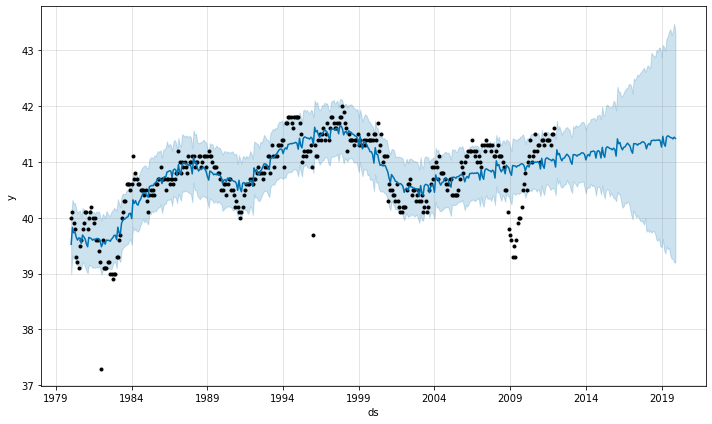

In [73]:
m.plot(forecast);

In [74]:
end = time.time()
print(end - start)

0.33022069931030273


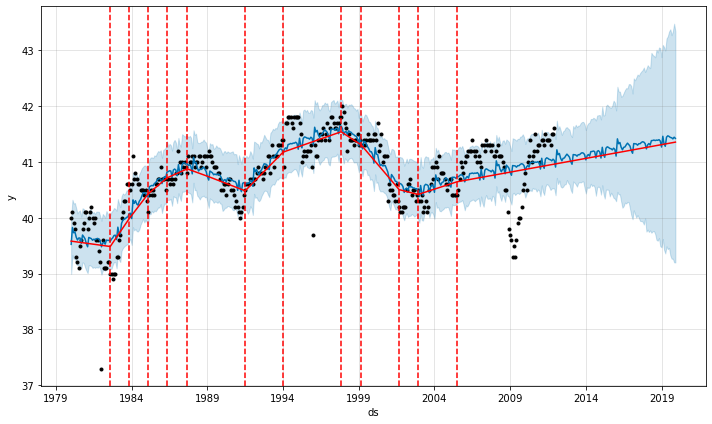

In [75]:
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Plot delle componenenti trovate da Prophet: trend(t) e seas(t)

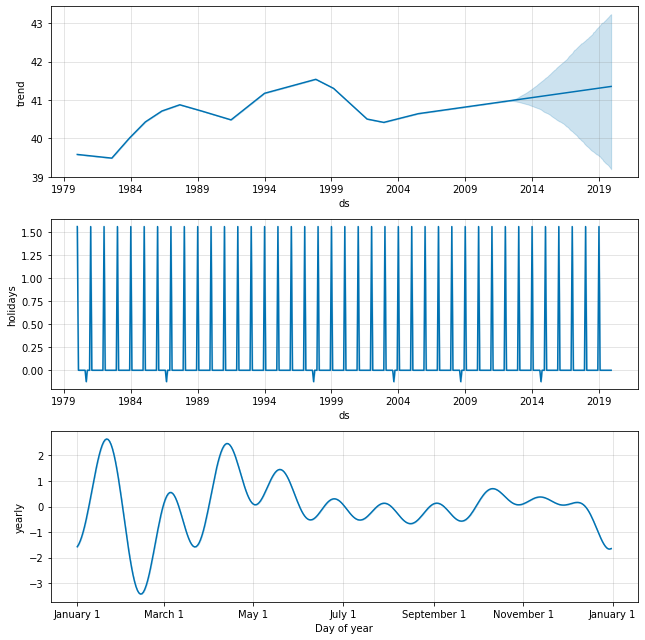

In [76]:
m.plot_components(forecast);

Disegno lo stesso diagramma creato in precedenza per ARIMA e RNN

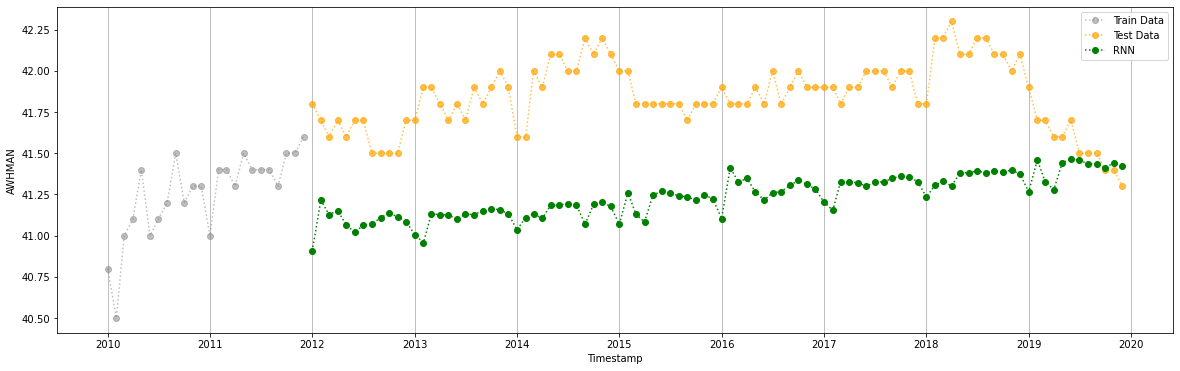

In [77]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[start_to_plot_train:],df_train[timeseries].iloc[start_to_plot_train:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],forecast[-96:]['yhat'],'o:',alpha=1, color='green')

plt.legend(['Train Data','Test Data','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_06_Prophet-pred-day_zoom_green', bbox_inches='tight')
plt.show()

In [78]:
mse = mean_squared_error(df_test[timeseries], forecast[-96:]['yhat'])
mae = mean_absolute_error(df_test[timeseries], forecast[-96:]['yhat'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.4241483256553997
RMSE  0.6512667085422068
MAE 0.6106816066866909


##### Predizione one-step con rimodellazione ######

In [79]:
start = time.time()

In [80]:
# Ad ogni passo del for aggiungo alla history un nuovo elemento preso dal "df_test"

predictions_prophet = list()

history = df_train[timeseries]

len_test = df_test.shape[0]

df_train_prophet = df_train[[timeseries,timestamp]].copy()

df_train_prophet = df_train_prophet.rename(columns={timeseries: "y", timestamp: "ds"})

for i in range(len_test):
    
    m = Prophet(growth='linear',
            n_changepoints=20,
            changepoint_range=0.8,
            weekly_seasonality=False, 
            daily_seasonality=False)
    
    m.add_country_holidays(country_name = "US")
    
    m.fit(df_train_prophet)
    
    future = m.make_future_dataframe(periods=1, freq='MS') # precisiamo che si tratta di mesi
    
    forecast = m.predict(future)
    
    predictions_prophet.append(forecast['yhat'][-1:].values[0])

    obs = df_test[timeseries].iloc[i]
    obs_ts = df_test[timestamp].iloc[i]
    
    df_train_prophet = df_train_prophet.append({'y': obs, 'ds': obs_ts}, ignore_index = True)    

In [81]:
end = time.time()
print(end - start)

347.33016633987427


In [82]:
df_test = df_test[[timeseries,timestamp]].iloc[0:]

df_test = df_test.reset_index(drop=True)

df_test['pred_prophet'] = pd.Series(predictions_prophet)

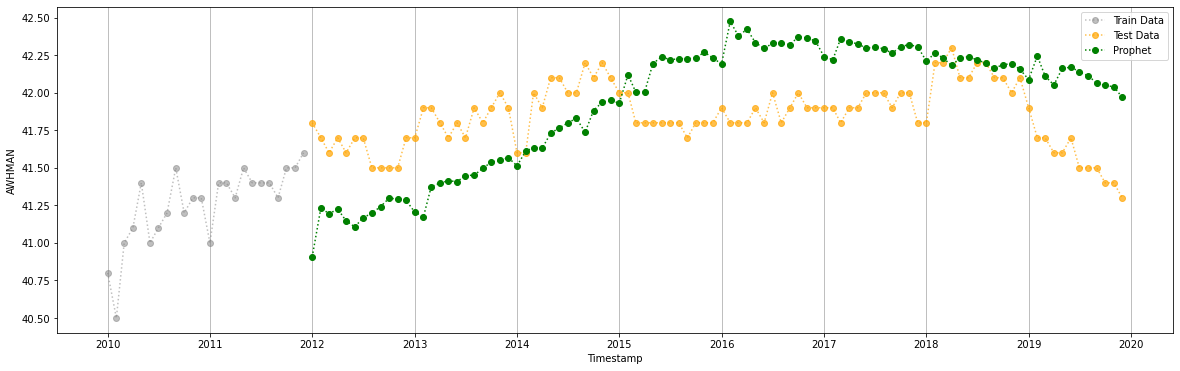

In [83]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[360:],df_train[timeseries].iloc[360:],'o:',alpha=0.5, color='grey')
plt.plot(df_test[timestamp],df_test[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test[timestamp],df_test['pred_prophet'],'o:',alpha=1, color='green')

plt.legend(['Train Data','Test Data','Prophet'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_prophet-pred-day_zoom_00_green', bbox_inches='tight')
plt.show()

In [84]:
mse = mean_squared_error(df_test[timeseries], df_test['pred_prophet'])
mae = mean_absolute_error(df_test[timeseries], df_test['pred_prophet'])

print('MSE ', mse)
print('RMSE ', sqrt(mse) )
print('MAE', mae)

MSE  0.16608813362311525
RMSE  0.4075391191322807
MAE 0.36532207606692685


In [85]:
df_test_results['pred_prophet'] = df_test['pred_prophet']

---

##### Conclusione #####

In [86]:
df_test_results.head()

timestamp  AWHMAN  pred_arima  pred_RNN_11  pred_prophet
0 2012-01-01    41.8   41.535927    40.516655     40.906906
1 2012-02-01    41.7   41.685333    40.589138     41.233625
2 2012-03-01    41.6   41.704267    40.545288     41.193876
3 2012-04-01    41.7   41.639574    40.685734     41.225610
4 2012-05-01    41.6   41.626412    40.594437     41.146577

In [87]:
models_list = []

for col in ['pred_arima', 'pred_RNN_11', 'pred_prophet']:
    mse = mean_squared_error(df_test_results[timeseries], df_test_results[col])
    mae = mean_absolute_error(df_test_results[timeseries], df_test_results[col])
    m_list = []
    m_list.append(col)
    m_list.append(mse)
    m_list.append(sqrt(mse))
    m_list.append(mae)
    
    models_list.append(m_list)

In [88]:
print(tabulate(models_list,headers=['Model','MSE','RMSE','MAE']))

Model               MSE      RMSE        MAE
------------  ---------  --------  ---------
pred_arima    0.0166662  0.129098  0.0982684
pred_RNN_11   1.77587    1.33262   1.3044
pred_prophet  0.166088   0.407539  0.365322


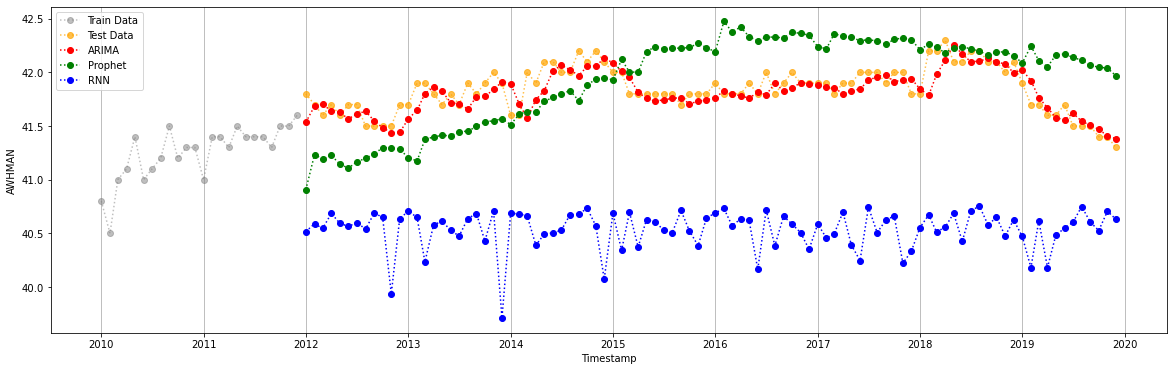

In [89]:
plt.figure(figsize=(20,6))

plt.plot(df_train[timestamp].iloc[360:],df_train[timeseries].iloc[360:],'o:',alpha=0.5, color='grey')
plt.plot(df_test_results[timestamp],df_test_results[timeseries],'o:',alpha=0.7, color='orange')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_arima'],'o:',alpha=1, color='red')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_prophet'],'o:',alpha=1, color='green')

#predicted values
plt.plot(df_test_results[timestamp],df_test_results['pred_RNN_11'],'o:',alpha=1, color='blue')

plt.legend(['Train Data','Test Data','ARIMA','Prophet','RNN'])

plt.ylabel(timeseries)
plt.xlabel('Timestamp')
plt.grid(axis = 'x')

plt.savefig('TS_05_pred-day_zoom', bbox_inches='tight')
plt.show()